In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np 
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [2]:
from gym.spaces import Box
from gym import Wrapper, ObservationWrapper
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

class CustomWrapper(Wrapper):
    def reset(self, **kwargs):
        kwargs.pop('seed', None)  # Remove the 'seed' argument
        kwargs.pop('options', None)  # Remove the 'options' argument
        return self.env.reset(**kwargs)

# Wrap your environment
env = CustomWrapper(env)

class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

    
class RemoveChannelDim(ObservationWrapper):
    def observation(self, observation):
        return np.squeeze(observation)
    
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = RemoveChannelDim(env)
env = FrameStack(env, num_stack=4)


In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os

2023-06-10 23:17:09.705229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 23:17:10.756027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './ppo/train/'
LOG_DIR = './ppo/logs/'

In [6]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [7]:
import torch as th
import torch.nn as nn
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(3136, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, features_dim))
            #nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)


In [8]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512, policy_kwargs=policy_kwargs) 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [9]:
from stable_baselines3.common.logger import configure

def train_model():
    env.reset()
    new_logger = configure(LOG_DIR, ["stdout", "csv"])
    # Set new logger 
    model.set_logger(new_logger)

    model.learn(total_timesteps=40000, callback=callback)

train_model()

Logging to ./ppo/logs/
----------------------------
| time/              |     |
|    fps             | 33  |
|    iterations      | 1   |
|    time_elapsed    | 15  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 2             |
|    time_elapsed         | 35            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0591466e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00027       |
|    learning_rate        | 1e-06         |
|    loss                 | 760           |
|    n_updates            | 10            |
|    policy_gradient_loss | -9.38e-05     |
|    value_loss           | 2.47e+03      |
--------------------------

KeyboardInterrupt: 

In [ ]:
#model.save('test_model')

In [ ]:
#env.close()

In [ ]:
# Load model
#model = PPO.load('test_model')
## Start the game 
#state = env.reset()
#print(type(state))
#print(state)
#print(env.action_space)
#observation_shape = state[0].shape
#print(observation_shape)
## Loop through the game
#while True: 
#    action, _states = model.predict(state[0])
#    state, reward, done, info = env.step(action)
#
#    env.render()
#
#    if done:
#        state = env.reset()
#        break  # Break the loop if the game is over


from stable_baselines3.common.evaluation import evaluate_policy

model = PPO.load("test_model")

obs = env.reset()

#cr = 0
#while True:
#    action, _states = model.predict(obs, deterministic=False)
#    obs, rewards, done, info = env.step(action)
#    env.step(action)
#    cr += rewards
#    print("Reward: {}\t\t".format(cr), end='\r')
#    env.render()
#    if (done):
#        print("Finished an episode with total reward: ", cr)
#        cr = 0
#        break


print(evaluate_policy(model, env, n_eval_episodes=2, deterministic=False, render=True))

print("Done.")


In [ ]:
env.close()

In [11]:
import pandas as pd

df = pd.read_csv("ppo/logs/progress.csv")
df

,time/fps,time/total_timesteps,time/iterations,time/time_elapsed,train/value_loss,train/learning_rate,train/clip_fraction,train/n_updates,train/clip_range,train/explained_variance,train/entropy_loss,train/loss,train/policy_gradient_loss,train/approx_kl,rollout/ep_rew_mean,rollout/ep_len_mean
0,33,512,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28,1024,2,35,2473.499306,0.000001,0.0,10.0,0.2,2.697110e-04,-1.945902,760.137024,-0.000094,1.059147e-06,NaN,NaN
2,28,1536,3,54,287.685600,0.000001,0.0,20.0,0.2,7.889271e-04,-1.945902,200.912506,-0.000070,1.050415e-06,1701.000000,1265.000000
3,27,2048,4,73,7064.046777,0.000001,0.0,30.0,0.2,5.965233e-04,-1.945901,3429.449951,-0.000012,6.536720e-07,1600.500000,854.500000
4,27,2560,5,92,3292.192752,0.000001,0.0,40.0,0.2,5.963445e-04,-1.945902,1477.534302,0.000038,9.706710e-07,1600.500000,854.500000
5,27,3072,6,112,999.817033,0.000001,0.0,50.0,0.2,-2.502203e-04,-1.945902,509.015228,-0.000125,2.779998e-06,1646.666667,889.666667
6,27,3584,7,132,3170.068651,0.000001,0.0,60.0,0.2,-7.152557e-07,-1.945899,1728.846558,-0.000013,5.359761e-07,1625.500000,876.000000
7,27,4096,8,150,3296.370892,0.000001,0.0,70.0,0.2,2.819300e-04,-1.945894,2055.074951,-0.000047,7.844064e-07,1625.500000,876.000000


In [12]:
df = df.fillna(0)
df

,time/fps,time/total_timesteps,time/iterations,time/time_elapsed,train/value_loss,train/learning_rate,train/clip_fraction,train/n_updates,train/clip_range,train/explained_variance,train/entropy_loss,train/loss,train/policy_gradient_loss,train/approx_kl,rollout/ep_rew_mean,rollout/ep_len_mean
0,33,512,1,15,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,28,1024,2,35,2473.499306,0.000001,0.0,10.0,0.2,2.697110e-04,-1.945902,760.137024,-0.000094,1.059147e-06,0.000000,0.000000
2,28,1536,3,54,287.685600,0.000001,0.0,20.0,0.2,7.889271e-04,-1.945902,200.912506,-0.000070,1.050415e-06,1701.000000,1265.000000
3,27,2048,4,73,7064.046777,0.000001,0.0,30.0,0.2,5.965233e-04,-1.945901,3429.449951,-0.000012,6.536720e-07,1600.500000,854.500000
4,27,2560,5,92,3292.192752,0.000001,0.0,40.0,0.2,5.963445e-04,-1.945902,1477.534302,0.000038,9.706710e-07,1600.500000,854.500000
5,27,3072,6,112,999.817033,0.000001,0.0,50.0,0.2,-2.502203e-04,-1.945902,509.015228,-0.000125,2.779998e-06,1646.666667,889.666667
6,27,3584,7,132,3170.068651,0.000001,0.0,60.0,0.2,-7.152557e-07,-1.945899,1728.846558,-0.000013,5.359761e-07,1625.500000,876.000000
7,27,4096,8,150,3296.370892,0.000001,0.0,70.0,0.2,2.819300e-04,-1.945894,2055.074951,-0.000047,7.844064e-07,1625.500000,876.000000


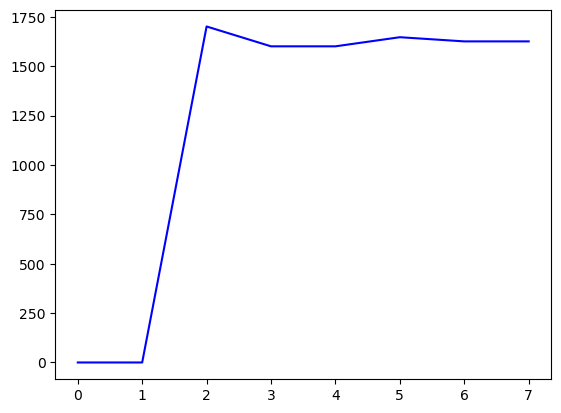

In [13]:
import matplotlib.pyplot as plt
ypoints = np.array(df['rollout/ep_rew_mean'].to_numpy())
plt.plot(ypoints, color = 'b')
plt.show()